In [1]:
# for data processing
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import numpy as np
# for visualisation
import matplotlib.pyplot as plt
# for network analysis
import osmnx as ox
import networkx as nx
import spaghetti
# for handling projections
import pyproj
# for random generation
import random

import warnings
warnings.filterwarnings('ignore')

/Users/mario/.pyenv/versions/3.8.14/lib/python3.8/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
# all the urls containing the csv files for the road traffic accidents data
urls = ['https://datamillnorth.org/download/road-traffic-accidents/8e6585f6-e627-4258-b16f-ca3858c0cc67/Traffic%2520accidents_2019_Leeds.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/8c100249-09c5-4aac-91c1-9c7c3656892b/RTC%25202018_Leeds.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/ca7e4598-2677-48f8-be11-13fd57b91640/Leeds_RTC_2017.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/b2c7ebba-312a-4b3d-a324-6a5eda85fa5b/Copy%2520of%2520Leeds_RTC_2016.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/df98a6dd-704e-46a9-9d6d-39d608987cdf/2015.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/fa7bb4b9-e4e5-41fd-a1c8-49103b35a60f/2014.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/56550461-ea6c-47d7-be61-73339b132547/2013.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/6ff5a09b-666a-4420-92ea-b6817b4a0f5c/2012.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/9204d06c-8e43-42d3-9ffa-87d806661801/2011.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/1ead4f5f-3636-4b8f-830c-7d2cc6f16084/2010.csv',
        'https://datamillnorth.org/download/road-traffic-accidents/288d2de3-0227-4ff0-b537-2546b712cf00/2009.csv']

# read in the csv files and convert them to geodataframes
# store the gdfs in a list
gdfs = []
for url in urls:
    df = pd.read_csv(url, encoding='latin1') # use latin1 encoding to ensure the data is read in correctly
    # crs='EPSG:27700' for lat/long coordinates
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[df.columns[1]], df[df.columns[2]]), crs='EPSG:27700')
    gdfs.append(gdf)

In [3]:
# concatenate the gdfs into one
gdf = pd.concat(gdfs, ignore_index=True)

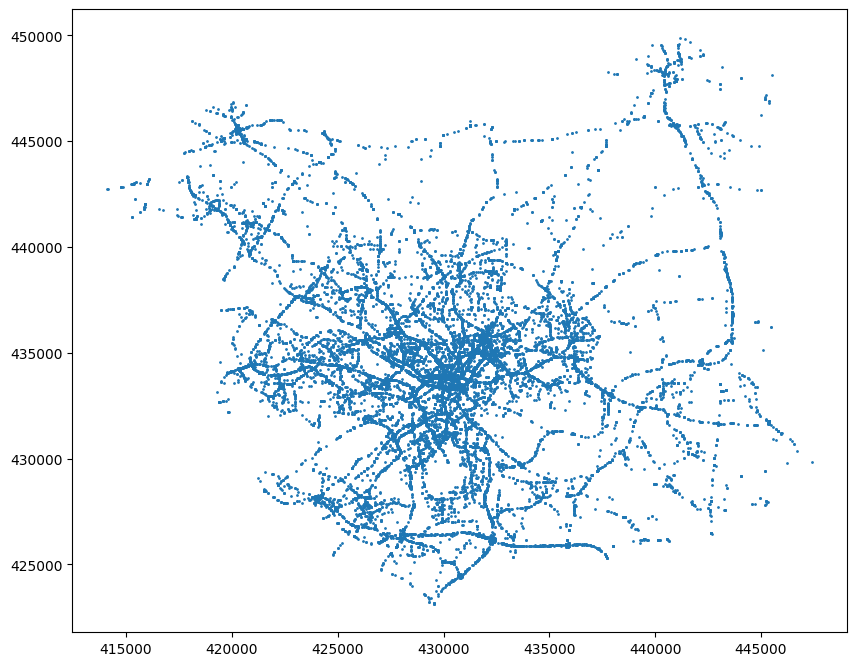

In [4]:
# visualise all the accidents in Leeds
gdf.plot(markersize=1, figsize=(10,10))
plt.show()

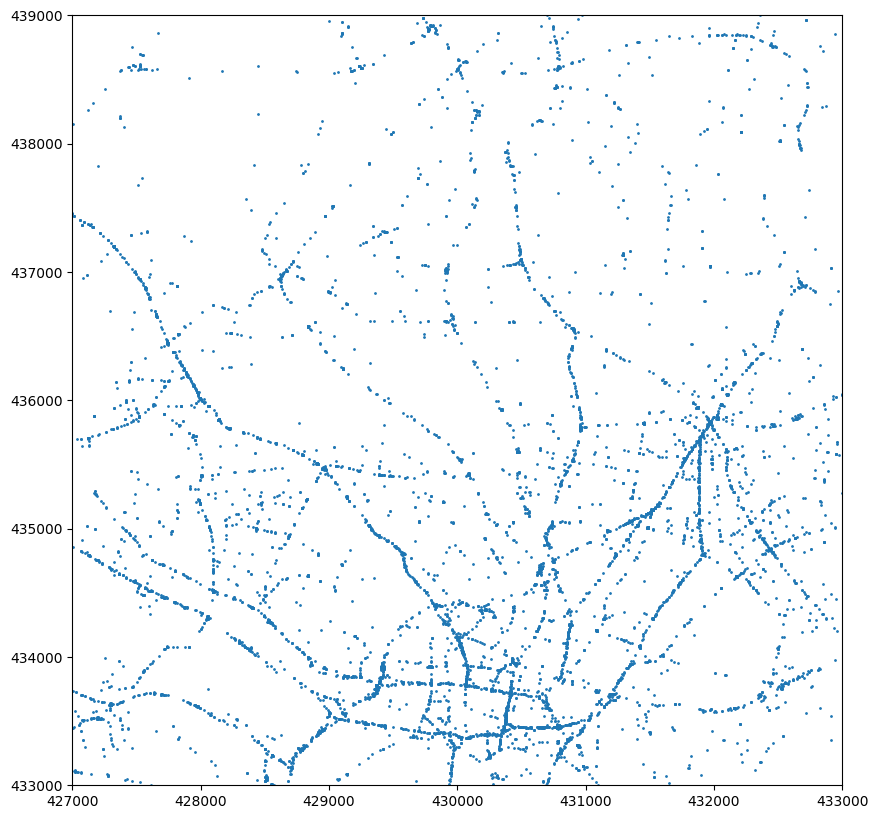

In [5]:
# zoom in to a dense area
gdf.plot(markersize=1, figsize=(10,10))
plt.xlim(427000, 433000)
plt.ylim(433000, 439000)
plt.show()

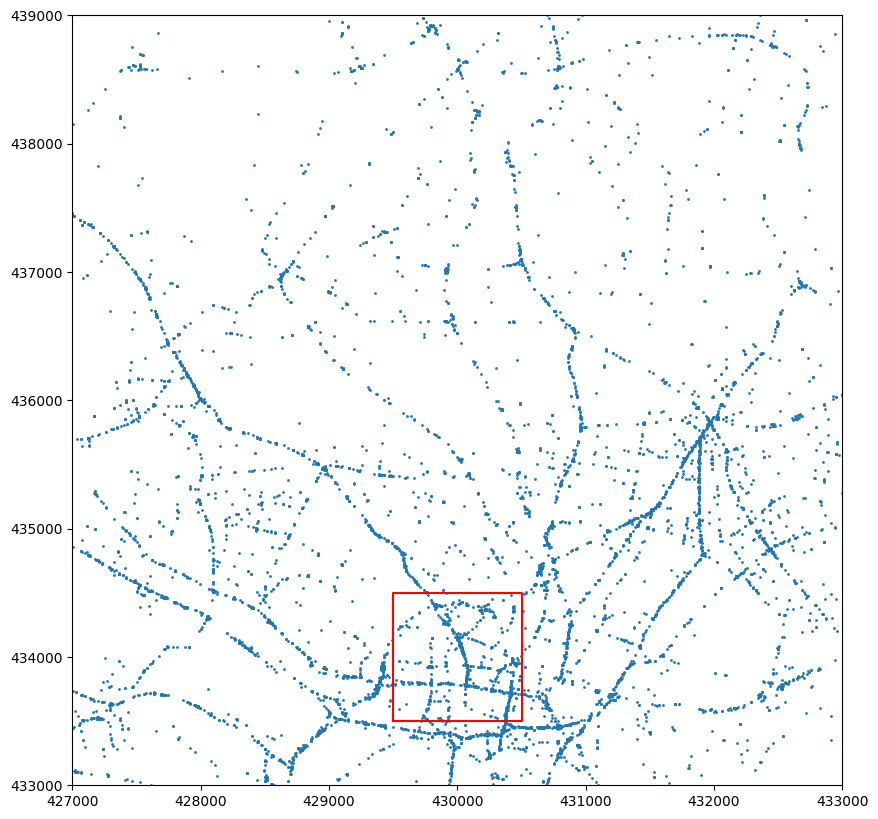

In [6]:
# select a 1 km x 1 km area of interest
CENTRE_OF_AREA = (430000, 434000)
AREA_OF_INTEREST = Polygon([(CENTRE_OF_AREA[0]-500, CENTRE_OF_AREA[1]-500),
                            (CENTRE_OF_AREA[0]+500, CENTRE_OF_AREA[1]-500),
                            (CENTRE_OF_AREA[0]+500, CENTRE_OF_AREA[1]+500),
                            (CENTRE_OF_AREA[0]-500, CENTRE_OF_AREA[1]+500)])

# visualise the area of interest
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax, markersize=1)
plt.xlim(427000, 433000)
plt.ylim(433000, 439000)
plt.plot(*AREA_OF_INTEREST.exterior.xy, color='red')
plt.show()

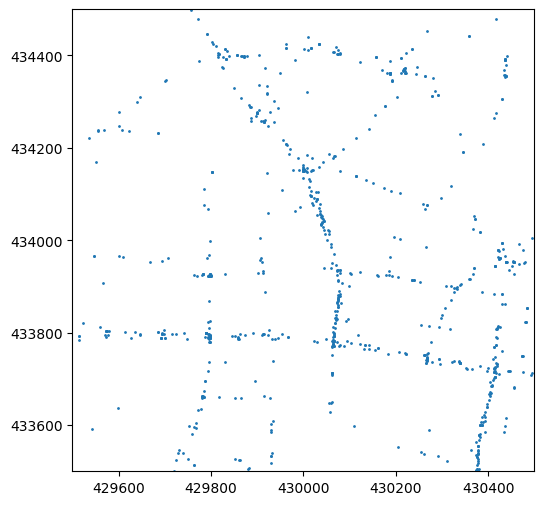

In [7]:
# zoom in to the area of interest
gdf.plot(markersize=1, figsize=(6,6))
plt.xlim(429500, 430500)
plt.ylim(433500, 434500)
plt.show()

In [8]:
# select the accidents within the area of interest
gdf_clipped = gdf[gdf['geometry'].within(AREA_OF_INTEREST)]
gdf_clipped = gdf_clipped[['Accident Date', 'geometry']].reset_index(drop=True)

# check the number of accidents
print('Number of accidents:', len(gdf_clipped))

Number of accidents: 847


In [9]:
from shapely.ops import transform

# reproject both the gdf and the area of interest to lat/long coordinates for osmnx
gdf_clipped = gdf_clipped.to_crs('EPSG:4326')
project = pyproj.Transformer.from_crs(pyproj.CRS('EPSG:27700'), pyproj.CRS('EPSG:4326'), always_xy=True).transform
AREA_OF_INTEREST = transform(project, AREA_OF_INTEREST)

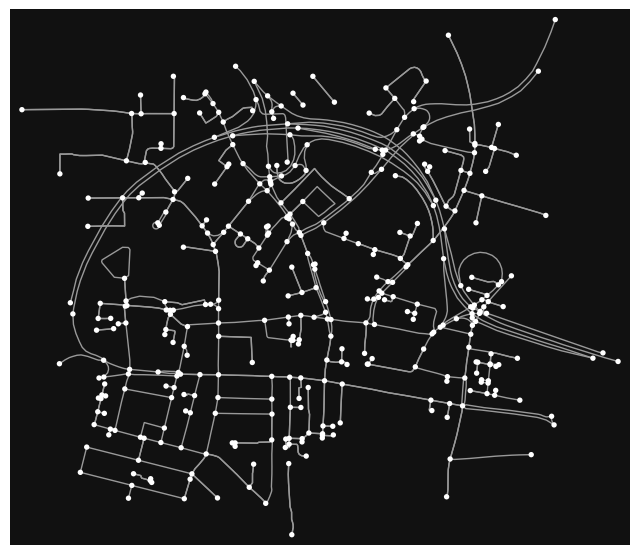

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [10]:
# retrieve the road network within the area of interest
G = ox.graph_from_polygon(AREA_OF_INTEREST, network_type='drive_service', truncate_by_edge=True, retain_all=True)
# and visualise it
ox.plot_graph(G)

In [11]:
# function to calculate the spatial diameter
def spatial_diameter(G):
    diameter = 0
    for u in G.nodes():
        # Find the shortest path from u to all other nodes
        dist = nx.shortest_path_length(G, source=u, weight='length')
        # Find the most distant node from u
        v = max(dist, key=dist.get)
        # Find the shortest path from u to v
        path = nx.shortest_path(G, source=u, target=v, weight='length')
        # Calculate the weighted length of the path
        path_length = sum(dict(G[s][e])[0]['length'] for s, e in zip(path[:-1], path[1:]))
        # Update the diameter if the new path is longer
        diameter = max(diameter, path_length)
    return diameter

In [12]:
spatial_diameter(G)

3012.5240000000003

In [13]:
# characteristics of the road network
ox.stats.basic_stats(G, area=1000000)

{'n': 387,
 'm': 675,
 'k_avg': 3.488372093023256,
 'edge_length_total': 42179.20699999991,
 'edge_length_avg': 62.487714074073935,
 'streets_per_node_avg': 2.5891472868217056,
 'streets_per_node_counts': {0: 0, 1: 101, 2: 5, 3: 237, 4: 40, 5: 4},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.26098191214470284,
  2: 0.012919896640826873,
  3: 0.6124031007751938,
  4: 0.10335917312661498,
  5: 0.0103359173126615},
 'intersection_count': 286,
 'street_length_total': 31194.143000000033,
 'street_segment_count': 469,
 'street_length_avg': 66.5120319829425,
 'circuity_avg': 1.0662223015902033,
 'self_loop_proportion': 0.0042643923240938165,
 'node_density_km': 387.0,
 'intersection_density_km': 286.0,
 'edge_density_km': 42179.20699999991,
 'street_density_km': 31194.143000000033}

The network is planar: False


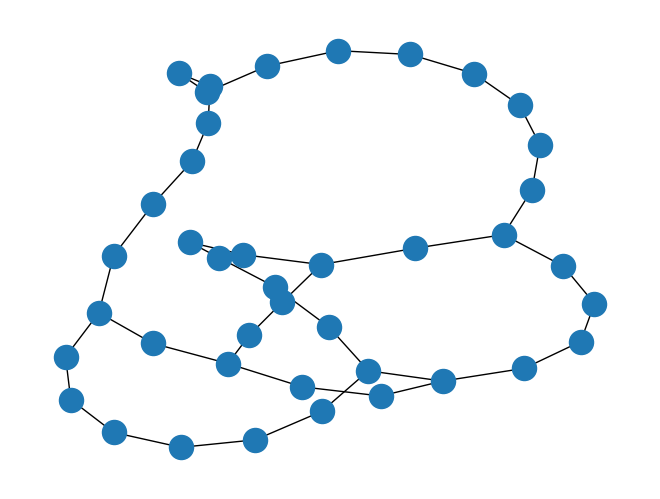

In [14]:
# check if the network is planar
is_planar, counterexample = nx.check_planarity(G, counterexample=True)
print(f'The network is planar: {is_planar}')
# and visualise the counterexample if it is not planar
nx.draw(counterexample)

In [15]:
# extract node coordinates
lon_values = nx.get_node_attributes(G, 'x')
lat_values = nx.get_node_attributes(G, 'y')

# extract edge information
edges_with_geom = list(G.edges(data=True))

# fill in the missing geometry information using the node coordinates
for edge in edges_with_geom:
    if 'geometry' not in edge[2]:
        edge[2]['geometry'] = LineString([(lon_values[edge[0]], lat_values[edge[0]]),
                                          (lon_values[edge[1]], lat_values[edge[1]])])

edges_with_geom[0]

(9791132,
 3871120536,
 {'osmid': 745709508,
  'oneway': False,
  'lanes': '2',
  'name': 'King Street',
  'highway': 'tertiary',
  'maxspeed': '30 mph',
  'reversed': False,
  'length': 51.251,
  'geometry': <shapely.geometry.linestring.LineString at 0x28a6a9af0>})

In [16]:
# load the edges into a geodataframe
edges_gdf = gpd.GeoDataFrame(pd.DataFrame([edge[2] for edge in edges_with_geom]), geometry='geometry')
edges_gdf.head()

osmid  oneway lanes                 name       highway maxspeed  \
0  745709508   False     2          King Street      tertiary   30 mph   
1    5944464    True   NaN           York Place  unclassified   20 mph   
2  609734125    True   NaN     Calverley Street      tertiary   20 mph   
3  175145751    True     2  Great George Street      tertiary   30 mph   
4  609729545   False   NaN     Calverley Street      tertiary   20 mph   

  reversed   length                                           geometry access  \
0    False   51.251  LINESTRING (-1.55041 53.79679, -1.55038 53.796...    NaN   
1    False  133.623  LINESTRING (-1.55440 53.79739, -1.55433 53.797...    NaN   
2    False   35.916  LINESTRING (-1.54910 53.80077, -1.54910 53.80109)    NaN   
3    False  116.220  LINESTRING (-1.54910 53.80077, -1.54848 53.800...    NaN   
4     True   18.050  LINESTRING (-1.54931 53.80254, -1.54922 53.80239)    NaN   

   ref tunnel bridge junction service  
0  NaN    NaN    NaN      NaN     NaN  
1  NaN    NaN    NaN      NaN     NaN  
2  NaN    NaN    NaN      NaN     NaN  
3  NaN    NaN    NaN      NaN     NaN  
4  NaN    NaN    NaN      NaN     NaN

In [17]:
# reproject both gdfs to the same crs (British National Grid) for easier calculation of distance
edges_gdf = edges_gdf.set_crs('EPSG:4326')
edges_gdf = edges_gdf.to_crs('EPSG:27700')
gdf_clipped = gdf_clipped.to_crs('EPSG:27700')

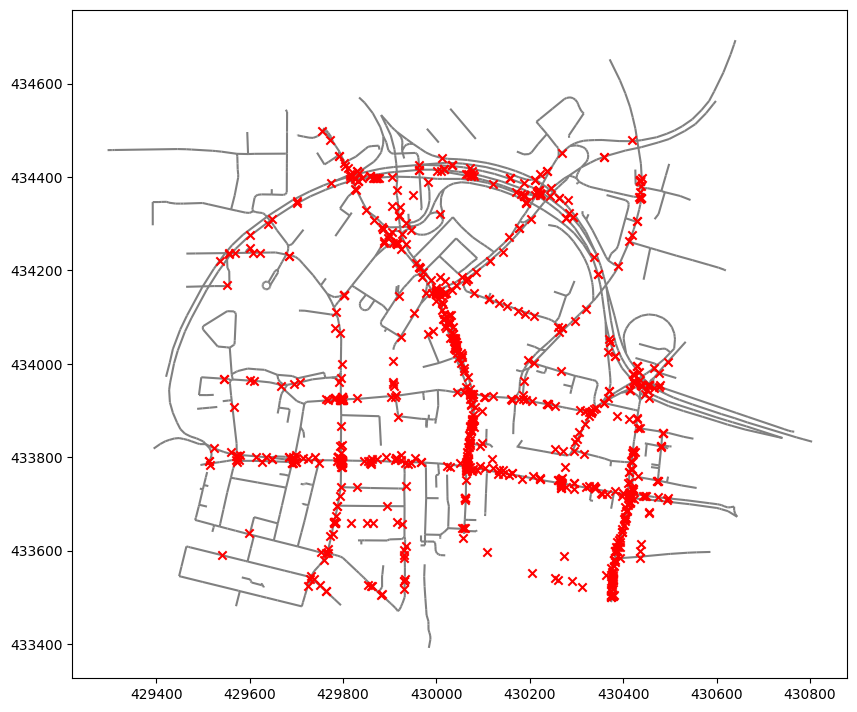

In [18]:
# create a spaghetti network from the edges geoDataFrame
road_network = spaghetti.Network(in_data=edges_gdf)
# add the accidents to the network
road_network.snapobservations(gdf_clipped, 'accidents', attribute=True)
edge_network_gdf = spaghetti.element_as_gdf(road_network, arcs=True)

# visualise the network with the accidents
base_network = edge_network_gdf.plot(color='grey', figsize=(10,10), zorder=0)
# show the actual locations of the accidents
accidents = spaghetti.element_as_gdf(road_network, pp_name='accidents')
accidents.plot(color='red', marker='x', zorder=1, ax=base_network)
plt.show()

In [19]:
# check the distance between the accidents and its snapped location on the network
# filter out those that are more than 20 metres away
accidents_to_remove = [k for k, v in road_network.pointpatterns['accidents'].dist_snapped.items() if v > 20]
filtered_accidents = gdf_clipped.drop(accidents_to_remove).reset_index(drop=True)

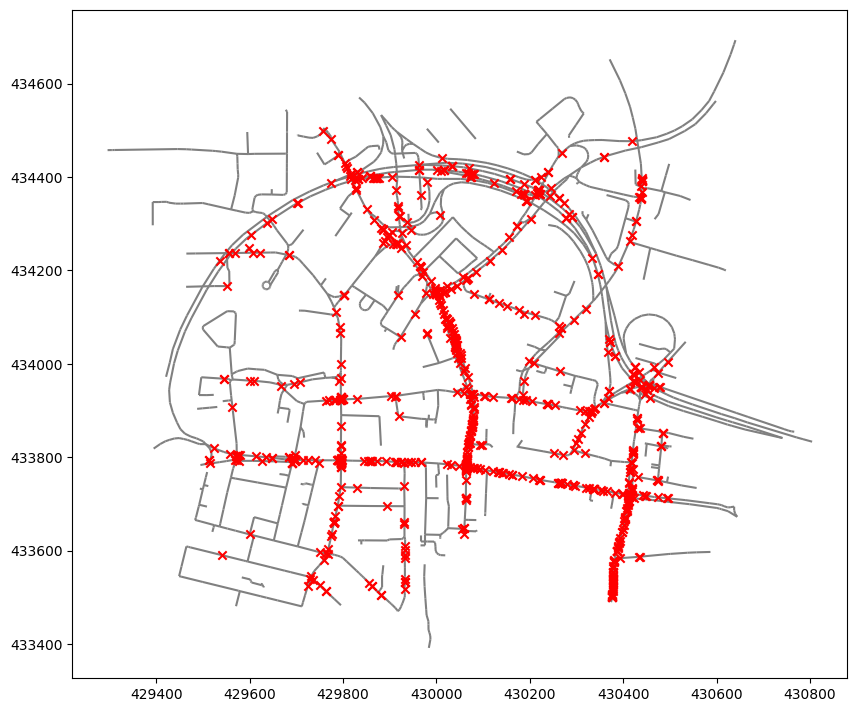

In [20]:
base_network = edge_network_gdf.plot(color='grey', figsize=(10,10), zorder=0)
# add the filtered accidents to the network
road_network.snapobservations(filtered_accidents, 'filtered_accidents', attribute=True)
# show the snapped locations of the filtered accidents
snapped_accidents = spaghetti.element_as_gdf(road_network, pp_name='filtered_accidents', snapped=True)
snapped_accidents.plot(color='red', marker='x', ax=base_network, zorder=1)
plt.show()

In [21]:
# count the number of accidents on each edge
counts = road_network.count_per_link(road_network.pointpatterns['filtered_accidents'].obs_to_arc, graph=False)

# get the weight matrix of the network's edges
weights = road_network.w_network

# get the edge ids and the number of accidents on each edge
edges = weights.neighbors.keys()
values = [counts[e] if e in counts.keys() else 0 for _, e in enumerate(edges)]

In [22]:
from esda.moran import Moran

# calculate the global moran's I using the constructed weight matrix and the number of accidents on each edge
moran = Moran(values, weights)
print(f'Global Moran\'s I: {moran.I:.3f}')
print(f'p-value: {moran.p_sim:.3f}')

('WARNING: ', (1186, 1187), ' is an island (no neighbors)')
('WARNING: ', (1258, 1259), ' is an island (no neighbors)')
Global Moran's I: 0.238
p-value: 0.001


In [23]:
# dist_to_vertex is a dictionary with the snapped accident locations as keys,
# and the distances to the left and right vertices of the snapped edge as values
# The fraction is then calculated as the minimum distance divided by the sum of the two distances (ranging from 0 to 0.5)
frac_accidents = [min(dists.values()) / sum(dists.values()) for _, dists \
    in road_network.pointpatterns['filtered_accidents'].dist_to_vertex.items()]

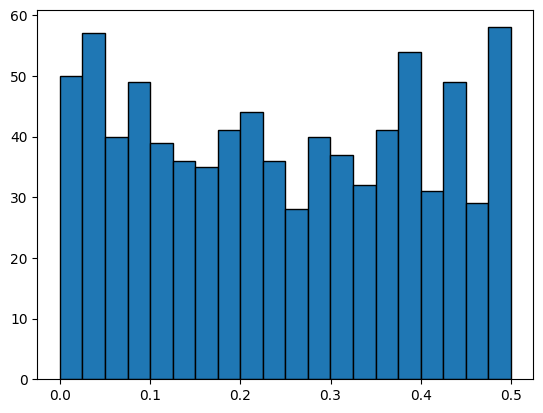

In [24]:
# plot the histogram of the fractions
plt.hist(frac_accidents, bins=20, edgecolor='black')
plt.show()

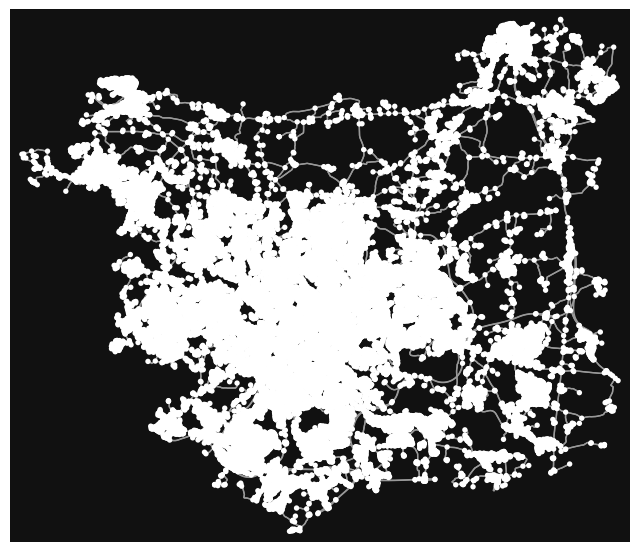

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [25]:
# retrieve the road network for Leeds
Leeds = ox.graph_from_place('Leeds, UK', network_type='drive_service')
ox.plot_graph(Leeds)

In [26]:
# extract node and edge coordinates, and fill in the missing geometry information
leeds_lon_vals = nx.get_node_attributes(Leeds, 'x')
leeds_lat_vals = nx.get_node_attributes(Leeds, 'y')
leeds_edges_with_geom = list(Leeds.edges(data=True))

for edge in leeds_edges_with_geom:
    if 'geometry' not in edge[2]:
        edge[2]['geometry'] = LineString([(leeds_lon_vals[edge[0]], leeds_lat_vals[edge[0]]),
                                          (leeds_lon_vals[edge[1]], leeds_lat_vals[edge[1]])])
        
leeds_edges_with_geom[0]

(154962,
 3504720,
 {'osmid': [143902122, 3998255],
  'oneway': True,
  'lanes': '2',
  'highway': 'motorway_link',
  'maxspeed': '70 mph',
  'reversed': False,
  'length': 549.2520000000001,
  'geometry': <shapely.geometry.linestring.LineString at 0x2a8e560a0>})

In [27]:
# load the edges into a gdf
leeds_edges_gdf = gpd.GeoDataFrame(pd.DataFrame([edge[2] for edge in leeds_edges_with_geom]), geometry='geometry', crs='EPSG:4326')
leeds_edges_gdf.head()

osmid  oneway lanes  \
0                               [143902122, 3998255]    True     2   
1        [329022404, 10416772, 329022405, 143902500]    True     3   
2                                           91015599    True     3   
3  [159243051, 146390928, 159243064, 145733243, 1...    True     3   
4                  [159243073, 159243066, 146391979]    True     3   

         highway maxspeed reversed    length  \
0  motorway_link   70 mph    False   549.252   
1       motorway   70 mph    False  1868.721   
2       motorway   70 mph    False  1637.739   
3       motorway   70 mph    False  1956.152   
4       motorway   70 mph    False  1020.994   

                                            geometry    ref bridge access  \
0  LINESTRING (-1.34293 53.84462, -1.34350 53.846...    NaN    NaN    NaN   
1  LINESTRING (-1.34293 53.84462, -1.34312 53.846...  A1(M)    yes    NaN   
2  LINESTRING (-1.49908 53.76173, -1.50067 53.761...     M1    NaN    NaN   
3  LINESTRING (-1.51734 53.74997, -1.51722 53.750...     M1    yes    NaN   
4  LINESTRING (-1.51734 53.74997, -1.51699 53.750...   M621    yes    NaN   

  name junction width service tunnel area  
0  NaN      NaN   NaN     NaN    NaN  NaN  
1  NaN      NaN   NaN     NaN    NaN  NaN  
2  NaN      NaN   NaN     NaN    NaN  NaN  
3  NaN      NaN   NaN     NaN    NaN  NaN  
4  NaN      NaN   NaN     NaN    NaN  NaN

In [28]:
# reproject to BNG
leeds_edges_gdf = leeds_edges_gdf.to_crs('EPSG:27700')

In [29]:
# load in the bus stops data to a pandas df
bus_stops = pd.read_csv('https://datamillnorth.org/download/west-yorkshire-bus-stops/5a713cfe-af6b-413b-8d94-7258a3feef6c/20181001_West_Yorkshire_Bus_Stops.csv')
bus_stops.head()

FID  STOPID                             NAME       TOWN  0730_0930  \
0    0   10001         Bodmin Road Helston Walk  Middleton          6   
1    1   10002      Bodmin Road Padstow Gardens  Middleton          6   
2    2   10003        Bodmin Road Padstow Place  Middleton          6   
3    3   10004      Bodmin Crescent Sissons Ter  Middleton          6   
4    4   10005  Ring Road Beeston Helston Croft  Middleton          9   

   1200_1400  1500_1830  2000_2100       x       y    z  \
0          6          4          2  428983  428480  120   
1          6          4          2  429117  428112  120   
2          6          4          2  429287  427872  120   
3          6          5          2  429447  427727  130   
4         10          6          5  429160  428503  130   

                                              PhotoF  \
0  http://apps.westyorks-ca.gov.uk/stopinformatio...   
1  http://apps.westyorks-ca.gov.uk/stopinformatio...   
2  http://apps.westyorks-ca.gov.uk/stopinformatio...   
3  http://apps.westyorks-ca.gov.uk/stopinformatio...   
4  http://apps.westyorks-ca.gov.uk/stopinformatio...   

                                              PhotoS  
0  http://apps.westyorks-ca.gov.uk/stopinformatio...  
1  http://apps.westyorks-ca.gov.uk/stopinformatio...  
2  http://apps.westyorks-ca.gov.uk/stopinformatio...  
3  http://apps.westyorks-ca.gov.uk/stopinformatio...  
4  http://apps.westyorks-ca.gov.uk/stopinformatio...

In [30]:
# convert the df to a gdf
bus_stops_gdf = gpd.GeoDataFrame(bus_stops, geometry=gpd.points_from_xy(bus_stops['x'], bus_stops['y']), crs='EPSG:27700')

In [31]:
# define the leeds area as the convex hull of the edges
leeds_area = leeds_edges_gdf.unary_union.convex_hull
# clip the bus stop gdf to contain only bus stops within the leeds area
bus_stops_gdf_clipped = bus_stops_gdf[bus_stops_gdf.within(leeds_area)]

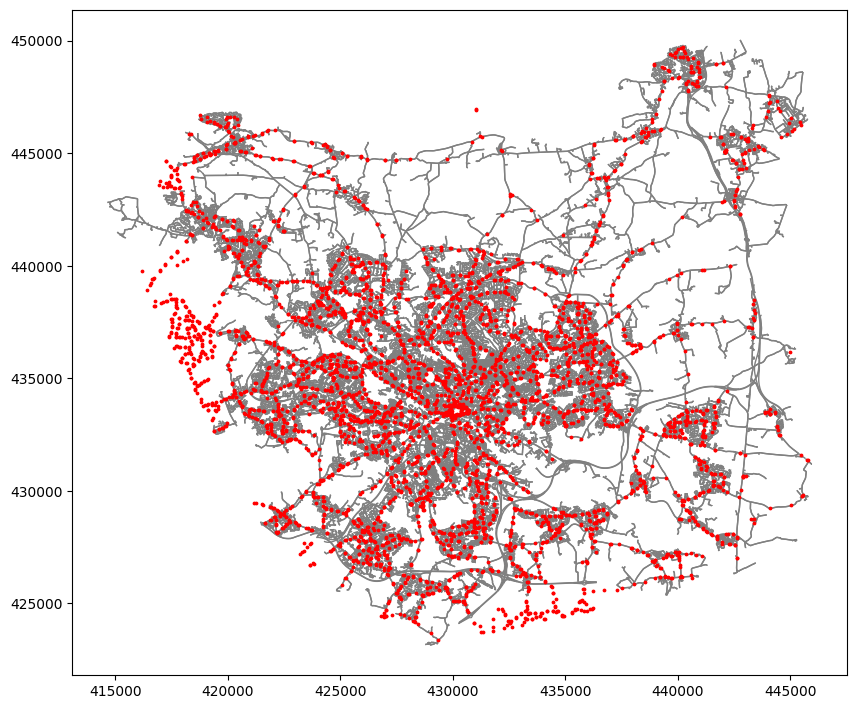

In [32]:
# visualise the bus stops along with the road network
base = leeds_edges_gdf.plot(color='grey', linewidth=1, figsize=(10,10), zorder=0)
bus_stops_gdf_clipped.plot(ax=base, color='red', markersize=3, zorder=1)
plt.show()

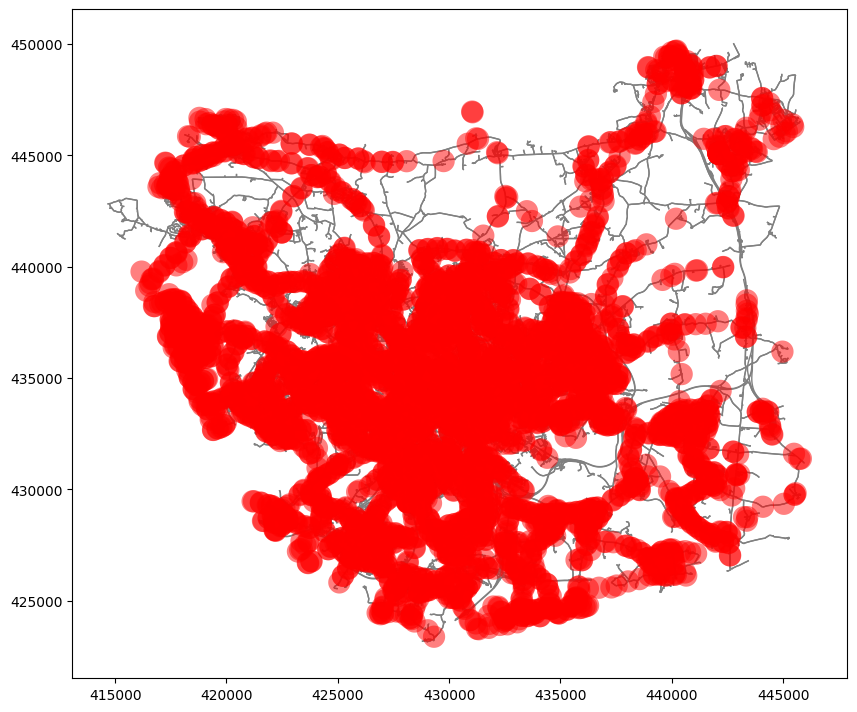

In [33]:
# create a 500m buffer around each bus stop
bus_stops_gdf_clipped['500m_buffer'] = bus_stops_gdf_clipped.buffer(500)
# and visualise the bus stop buffers
base = leeds_edges_gdf.plot(color='grey', linewidth=1, figsize=(10,10), zorder=0)
bus_stops_gdf_clipped['500m_buffer'].plot(ax=base, color='red', alpha=0.5, zorder=1)
plt.show()

In [34]:
# create a unary union of the bus stop buffers ( a single polygon containing all the buffers)
bus_stops_500m_buffer = bus_stops_gdf_clipped['500m_buffer'].unary_union

In [35]:
# check the edge density of the network
print(f'Edge density: {ox.stats.edge_length_total(Leeds) / (leeds_area.area / 1000 ** 2)} m/km^2')

Edge density: 12040.223784952792 m/km^2


In [36]:
# function to generate a random point within a polygon
def generate_random_points_within_polygon(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    point = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
    if polygon.contains(point):
        return point
    else:
        return generate_random_points_within_polygon(polygon)

# function to generate n random points within a polygon, ensuring that no two points are closer than 4km
def generate_n_random_points_within_polygon(polygon, n):
    points = []
    while len(points) < n:
        new_point = generate_random_points_within_polygon(polygon)
        exit_flag = False
        for point in points:
            if new_point.distance(point) < 4000:
                exit_flag = True
                break
        if exit_flag:
            continue
        points.append(new_point)
    return points

In [37]:
# generate 10 random points within the bus stop buffer
# points = generate_n_random_points_within_polygon(bus_stops_500m_buffer, 10)
# convert the points list to a gdf
# points_gdf = gpd.GeoDataFrame(pd.DataFrame({'geometry': points}), geometry='geometry', crs='EPSG:27700')

In [38]:
# for regeneration purpose
# points_gdf.to_file('data/seed_points.shp')

In [39]:
# for regeneration purpose
points_gdf = gpd.read_file('data/seed_points.shp')

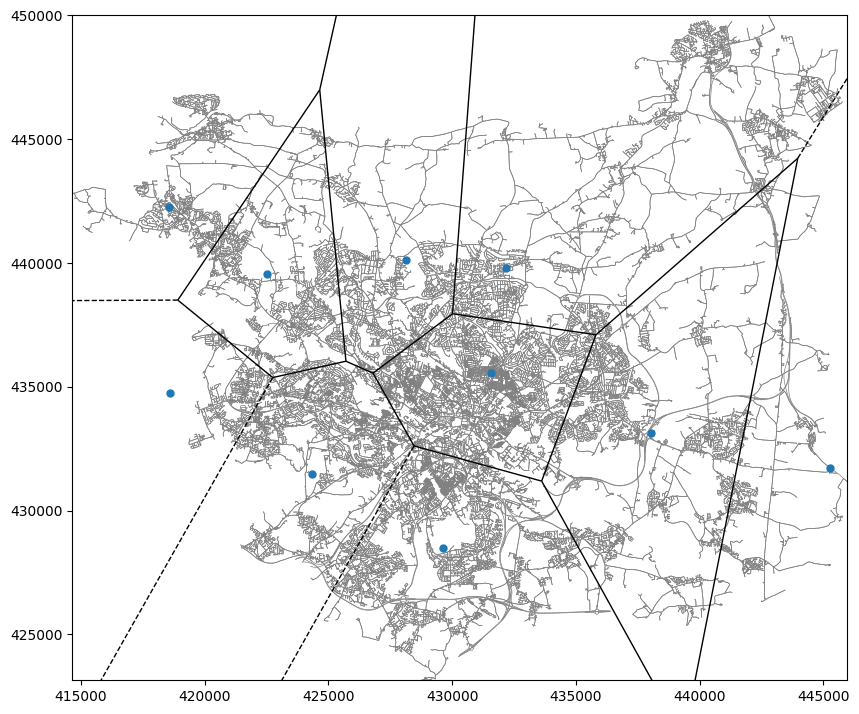

In [40]:
from scipy.spatial import Voronoi, voronoi_plot_2d
# generate the voronoi diagram with the seed points
# and visualise them on top of the road network
base = leeds_edges_gdf.plot(color='grey', linewidth=0.5, figsize=(10,10), zorder=0)
minx, miny, maxx, maxy = leeds_area.bounds
vor = Voronoi([[point.xy[0][0], point.xy[1][0]] for point in points_gdf['geometry']])
voronoi_plot = voronoi_plot_2d(vor, point_size=10, ax=base, show_vertices=False)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()

In [41]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

In [42]:
# extract the voronoi regions and vertices from the Voronoi object
vor_regions, vor_vertices = voronoi_finite_polygons_2d(vor)

In [43]:
# function to convert the voronoi regions and vertices to a gdf containing polygons
def get_voronoi_cells_gdf(vor_regions, vor_vertices):
    vor_cells = []
    for region in vor_regions:
        cell = Polygon(vor_vertices[v] for v in region)
        vor_cells.append(cell)
    return gpd.GeoDataFrame(pd.DataFrame({'geometry': vor_cells}), geometry='geometry', crs='EPSG:27700')

In [44]:
# convert the voronoi regions and vertices to a gdf
vor_cells_gdf = get_voronoi_cells_gdf(vor_regions, vor_vertices)

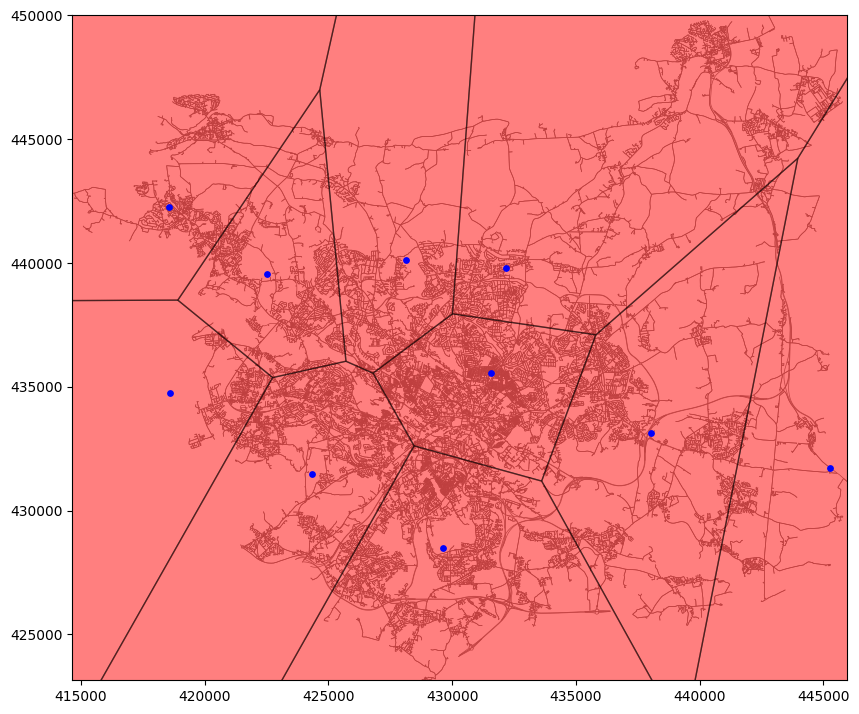

In [45]:
# visualise the voronoi cell polygons
base = leeds_edges_gdf.plot(color='grey', linewidth=0.5, figsize=(10,10), zorder=0)
minx, miny, maxx, maxy = leeds_area.bounds
vor_cells_gdf.plot(ax=base, color='red', linewidth=1, edgecolor='black', alpha=0.5, zorder=1)
points_gdf.plot(ax=base, color='blue', markersize=15, zorder=2)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()

In [46]:
# function to extract the subgraph of the road network within each voronoi cell
def get_subgraph_within_cell(graph, vor_cells_gdf):
    latlon_vor_cells_gdf = vor_cells_gdf.to_crs('EPSG:4326')
    leeds_nodes_gdf = ox.graph_to_gdfs(graph, nodes=True, edges=False)
    G_cells = []
    for cell in latlon_vor_cells_gdf.geometry:
        nodes_intersection = leeds_nodes_gdf[leeds_nodes_gdf.geometry.intersects(cell)].index
        G_cells.append(graph.subgraph(nodes_intersection))
    return G_cells

In [47]:
# extract all the subgraphs and convert them to undirected graphs
# because we do not care about the direction of a road during a marathon
G_cells = get_subgraph_within_cell(Leeds, vor_cells_gdf)
G_cells = [nx.Graph(G) for G in G_cells]

In [48]:
# function to (naively) find a circuit of a given length within a graph
def find_circuit_with_target_length_2(graph, target_length):
    # initialise variables
    path = []
    path_length = 0

    # loop through all nodes
    # the nx.all_pairs_dijkstra() function computes the shortest path between each node and all other nodes
    # it returns a dictionary with the key being the node, 
    # and the value being a tuple containing two dictionaries containing the shortest path length and the shortest path to a node
    # we set the cutoff to save time, which stops the search when the shortest path length is greater than the cutoff
    for start, (distances, paths) in nx.all_pairs_dijkstra(graph, weight='length', cutoff=target_length/2+1000):
        # for each path, check if its length is within 1000m of half of the target length
        for end, d in distances.items():
            # if it is, add the found half path to the path variable
            # set the path length to the length of the half path
            # then break out of the current loop and move on the find the second half of the path
            if target_length/2 - 1000 <= d <= target_length/2 + 1000:
                path = paths[end]
                path_length = d
                break
        # if the path variable is empty, it means that no first half was found
        # so we move on to the next node
        if not path:
            continue
        
        # otherwise, we have found a first half
        # so we copy the graph and remove the edges in the first half    
        graph_c = graph.copy()
        for i in range(len(path)-1):
            graph_c.remove_edge(path[i], path[i+1])
        
        # then we try to find the second half to form a circuit
        try:
            # the second half exactly starts from the end of the first half, and ends at the start of the first half
            path_length += nx.dijkstra_path_length(graph_c, path[-1], start, weight='length')
            path_c = nx.dijkstra_path(graph_c, path[-1], start, weight='length')
            # if the total length of the circuit is within 100m of the target length, we say we have found a circuit
            if target_length - 100 <= path_length <= target_length + 100:
                # add the second half to the path variable
                path += path_c[1:]
                # and break out of the current loop
                break
        # if no such path was found, pass on
        except nx.NetworkXNoPath:
            pass
        # if the function reached this point, it means that no circuit was found for the current node
        # so we reset the path and path length variables
        path = []
        path_length = 0
    
    return path, path_length

In [49]:
# function to (naively) find a circuit of a given length within a graph
def find_circuit_with_target_length(graph, target_length):
    # initialise variables
    path = []
    path_length = 0

    # loop through all nodes
    # the nx.all_pairs_dijkstra() function computes the shortest path between each node and all other nodes
    # it returns a dictionary with the key being the node, 
    # and the value being a tuple containing two dictionaries containing the shortest path length and the shortest path to a node
    # we set the cutoff to save time, which stops the search when the shortest path length is greater than the cutoff
    for start, (distances, paths) in nx.all_pairs_dijkstra(graph, weight='length', cutoff=target_length/2+1000):
        # for each path, check if its length is within 1000m of half of the target length
        for end, d in distances.items():
            # if the length is within 1000m of half of the target length, we have found a first half
            if target_length/2 - 1000 <= d <= target_length/2 + 1000:
                # add the first half to the path variable
                path = paths[end]
                # set the path length to the first half length
                path_length = d
                # hard copy the graph and remove the edges in the first half
                graph_c = graph.copy()
                for i in range(len(path)-1):
                    graph_c.remove_edge(path[i], path[i+1])
                
                # then we try to find the second half from the copy graph to form a circuit
                try:
                    # the second half exactly starts from the end of the first half, and ends at the start of the first half
                    path_length += nx.dijkstra_path_length(graph_c, path[-1], start, weight='length')
                    path_c = nx.dijkstra_path(graph_c, path[-1], start, weight='length')
                    # if the total length of the circuit is within 100m of the target length, we say we have found a circuit
                    if target_length - 100 <= path_length <= target_length + 100:
                        # add the second half to the path variable
                        path += path_c[1:]
                        # and return the found path and path length
                        return path, path_length
                # if no such path was found, pass on
                except nx.NetworkXNoPath:
                    pass
                # if the function reached this point, it means that no circuit was found for the current pair of nodes
                # so we reset the path and path length variables and move on to the next end node
                path = []
                path_length = 0
    
    # finally if no circuit was found, return an empty path and a path length of 0
    return path, path_length

In [51]:
# function to find circuits of a given length within a list of graphs
def find_circuits(G_cells, target_length):
    paths_cells = []
    # for each graph in the list of graphs
    for i, G in enumerate(G_cells):
        print('=====================')
        print(f'Now processing cell {i+1}')
        print(f'It has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')
        # find a circuit of the target length
        path, length = find_circuit_with_target_length(G, target_length)
        if path:
            print(f'Path found with length: {length}')
        else:
            print('Path NOT found.')
        # append the result to a list
        paths_cells.append(path)
    
    return paths_cells

In [52]:
paths_cells = find_circuits(G_cells, 42000)

Now processing cell 1
It has 1447 nodes and 1561 edges.
Path NOT found.
Now processing cell 2
It has 1346 nodes and 1511 edges.
Path NOT found.
Now processing cell 3
It has 10689 nodes and 13026 edges.
Path NOT found.
Now processing cell 4
It has 6652 nodes and 7414 edges.
Path NOT found.
Now processing cell 5
It has 9563 nodes and 10854 edges.
Path NOT found.
Now processing cell 6
It has 6903 nodes and 7784 edges.
Path NOT found.
Now processing cell 7
It has 3146 nodes and 3541 edges.
Path NOT found.
Now processing cell 8
It has 3575 nodes and 3999 edges.
Path NOT found.
Now processing cell 9
It has 6239 nodes and 6927 edges.
Path found with length: 41925.331999999995
Now processing cell 10
It has 2549 nodes and 2847 edges.
Path NOT found.


In [53]:
vor_cells_gdf_clipped = gpd.clip(vor_cells_gdf, leeds_area)

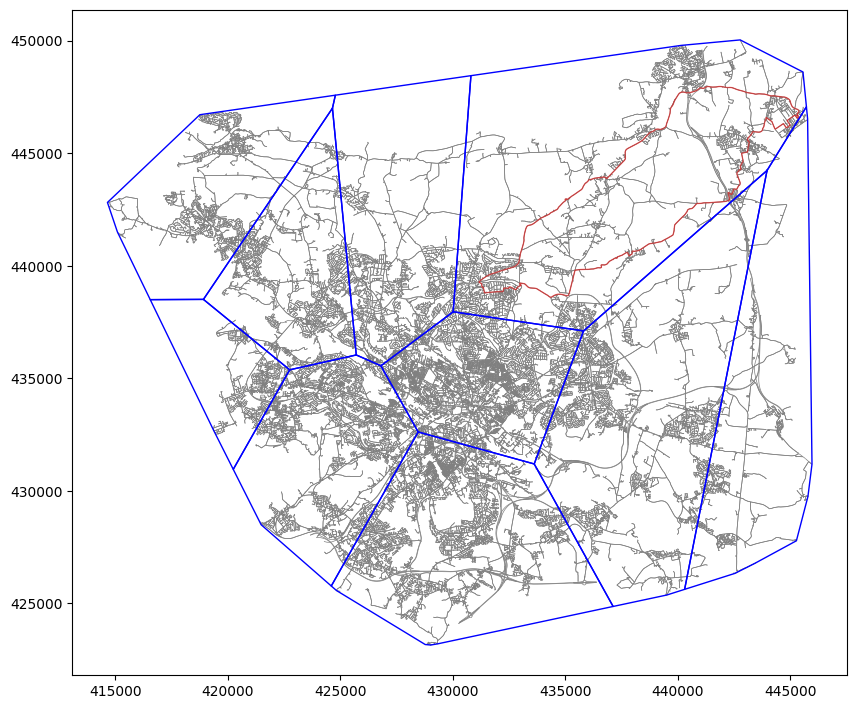

In [54]:
base = leeds_edges_gdf.plot(color='grey', linewidth=0.5, figsize=(10,10), zorder=0)
for i, path in enumerate(paths_cells):
    plt.plot(*vor_cells_gdf_clipped.loc[i, 'geometry'].exterior.xy, color='blue', linewidth=1, zorder=1)
    if path:
        edges_in_path = [G_cells[i][path[j]][path[j+1]] for j in range(len(path)-1)]
        edges_in_path_gdf = gpd.GeoDataFrame(pd.DataFrame(edges_in_path), geometry='geometry', crs='EPSG:4326')
        edges_in_path_gdf = edges_in_path_gdf.to_crs('EPSG:27700')
        edges_in_path_gdf.plot(color='red', linewidth=1, alpha=0.5, ax=base, zorder=2)
plt.show()

In [65]:
# for regeneration
m_points = generate_n_random_points_within_polygon(bus_stops_500m_buffer, 5)
m_points_gdf = gpd.GeoDataFrame(pd.DataFrame({'geometry': m_points}), geometry='geometry', crs='EPSG:27700')
m_points_gdf.to_file('data/m_seed_points.shp')

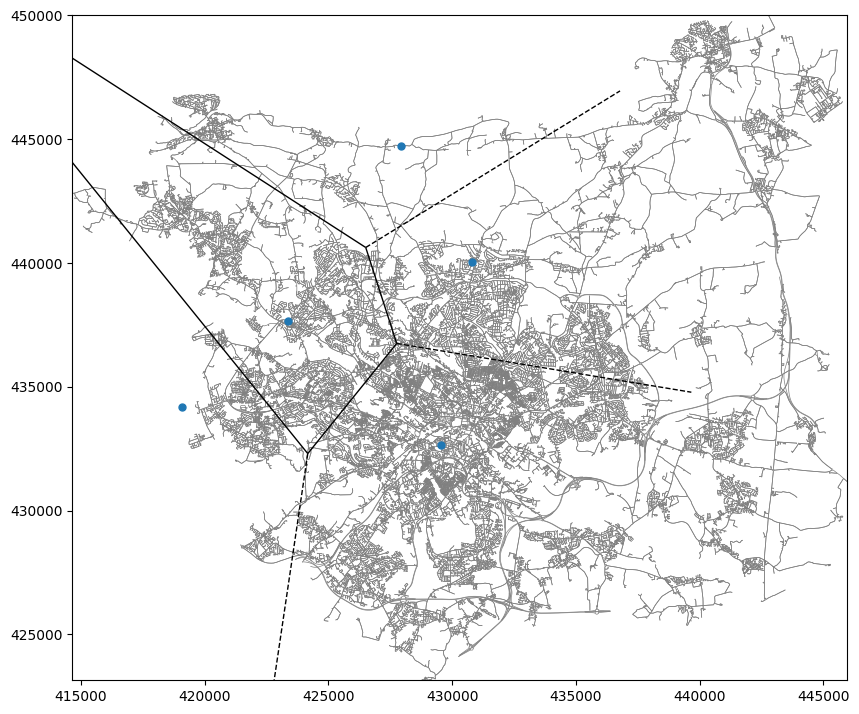

In [60]:
m_points_gdf = gpd.read_file('data/m_seed_points.shp')

base = leeds_edges_gdf.plot(color='grey', linewidth=0.5, figsize=(10,10), zorder=0)
minx, miny, maxx, maxy = leeds_area.bounds
m_vor = Voronoi([[point.xy[0][0], point.xy[1][0]] for point in m_points_gdf['geometry']])
voronoi_plot = voronoi_plot_2d(m_vor, point_size=10, ax=base, show_vertices=False)
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)
plt.show()

In [61]:
m_vor_regions, m_vor_vertices = voronoi_finite_polygons_2d(m_vor)

m_vor_cells_gdf = get_voronoi_cells_gdf(m_vor_regions, m_vor_vertices)

m_G_cells = get_subgraph_within_cell(Leeds, m_vor_cells_gdf)
m_G_cells = [nx.Graph(G) for G in m_G_cells]

m_paths_cells = find_circuits(m_G_cells, 42000)

Now processing cell 1
It has 28058 nodes and 32706 edges.
Path found with length: 42084.47200000001
Now processing cell 2
It has 1893 nodes and 2067 edges.
Path NOT found.
Now processing cell 3
It has 2609 nodes and 2863 edges.
Path NOT found.
Now processing cell 4
It has 8491 nodes and 9628 edges.
Path NOT found.
Now processing cell 5
It has 11058 nodes and 12463 edges.
Path found with length: 42056.43999999999


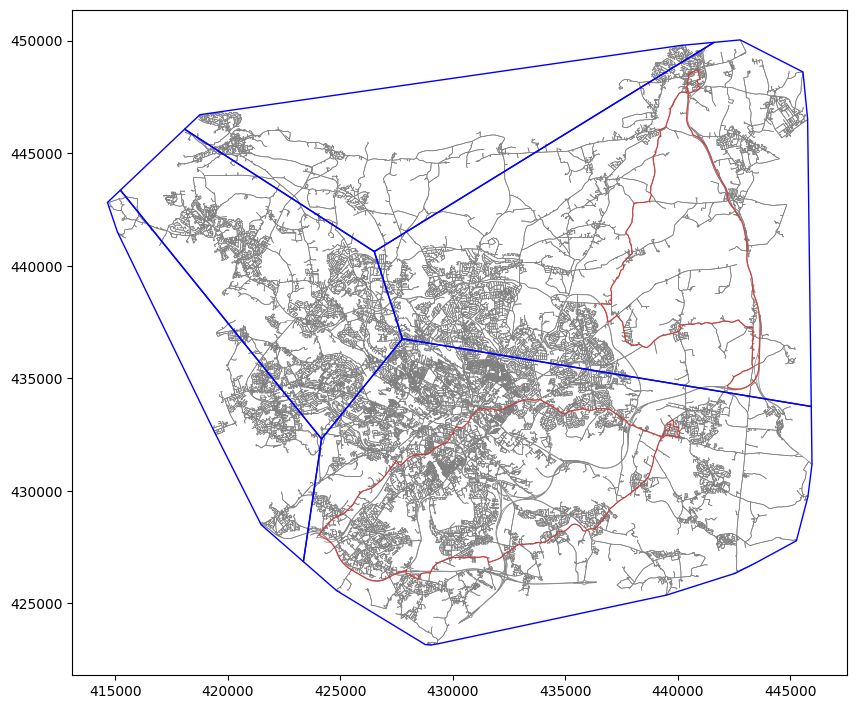

In [62]:
m_vor_cells_gdf_clipped = gpd.clip(m_vor_cells_gdf, leeds_area)
base = leeds_edges_gdf.plot(color='grey', linewidth=0.5, figsize=(10,10), zorder=0)
for i, path in enumerate(m_paths_cells):
    plt.plot(*m_vor_cells_gdf_clipped.loc[i, 'geometry'].exterior.xy, color='blue', linewidth=1, zorder=1)
    if path:
        edges_in_path = [m_G_cells[i][path[j]][path[j+1]] for j in range(len(path)-1)]
        edges_in_path_gdf = gpd.GeoDataFrame(pd.DataFrame(edges_in_path), geometry='geometry', crs='EPSG:4326')
        edges_in_path_gdf = edges_in_path_gdf.to_crs('EPSG:27700')
        edges_in_path_gdf.plot(color='red', linewidth=1, alpha=0.5, ax=base, zorder=2)
plt.show()